[![Open In Colab](https://colab.research.google.com/github/Vedant2100/w26/blob/main/CS%20228/bot_exploration.ipynb)

# Buffer of Thought (BoT) Exploration
## Memory-Based Agentic Framework for LLM Agents

**Project:** A Controlled Comparative Study of Reactive and Planning Strategies in LLM-based Agents  
**Team Member:** Vedant Deepak Borkute  
**Method:** BoT (Memory Based)  
**Environment:** OpenAI Gym Minigrid  

### Research Objectives
- Implement and benchmark Buffer of Thought (BoT) agent on navigation tasks
- Compare memory-based reasoning against reactive and planning strategies
- Evaluate performance metrics: success rate, steps to completion, inference time, token usage

### What is Buffer of Thought?
BoT is a memory-augmented reasoning framework where the agent maintains a buffer of past observations, actions, and reasoning traces. This allows the LLM to:
- Build cumulative understanding across multiple steps
- Reference past decisions to inform current choices
- Adapt strategies based on historical success/failure patterns

In [20]:
! pip install minigrid

## 1. Import Required Libraries

In [21]:
# Core Libraries
import os
import json
import time
from datetime import datetime
from collections import deque
from typing import List, Dict, Tuple, Any
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Minigrid Environment
try:
    import gymnasium as gym
    import minigrid
    from minigrid.core.actions import Actions
    from minigrid.wrappers import FullyObsWrapper
    print("✓ Minigrid environment loaded")
except ImportError:
    print("! Install with: pip install gymnasium minigrid")

# LLM API (OpenAI/Anthropic/etc.)
try:
    import openai
    from openai import OpenAI
    print("✓ OpenAI API loaded")
except ImportError:
    print("! Install with: pip install openai")

print("\n=== Environment Setup Complete ===")

✓ Minigrid environment loaded
! Install with: pip install openai

=== Environment Setup Complete ===


## 2. Define Buffer of Thought Architecture

In [22]:
from dataclasses import dataclass, field

@dataclass
class ThoughtTemplate:
    name: str
    description: str
    reasoning_pattern: str
    usage_count: int = 0
    success_rate: float = 0.0

class MetaBuffer:
    def __init__(self):
        self.templates = {}
        self._initialize_default_templates()

    def _initialize_default_templates(self):
        # Basic navigation template
        self.add_template(ThoughtTemplate(
            name="Direct Navigation",
            description="Moving towards a visible target in an empty space.",
            reasoning_pattern="1. Locate target coordinates. 2. Identify relative direction. 3. Align orientation. 4. Move forward."
        ))
        # Obstacle avoidance template
        self.add_template(ThoughtTemplate(
            name="Obstacle Avoidance",
            description="Navigating around walls or closed doors.",
            reasoning_pattern="1. Identify blocking object. 2. Scan for open path. 3. Plan detour. 4. Execute lateral move."
        ))

    def add_template(self, template: ThoughtTemplate):
        self.templates[template.name] = template

    def retrieve(self, problem_description: str) -> ThoughtTemplate:
        # Simple keyword matching for retrieval (BoT uses semantic similarity)
        if "wall" in problem_description.lower() or "door" in problem_description.lower():
            return self.templates["Obstacle Avoidance"]
        return self.templates["Direct Navigation"]

class ProblemDistiller:
    @staticmethod
    def distill(obs_text: str) -> str:
        # In this implementation, the obs_text is already distilled by the wrapper
        return obs_text

class BufferManager:
    def __init__(self):
        self.meta_buffer = MetaBuffer()
        self.thought_history = deque(maxlen=50)

    def get_reasoning_aid(self, distilled_problem: str) -> str:
        template = self.meta_buffer.retrieve(distilled_problem)
        return f"[TEMPLATE: {template.name}]\n{template.reasoning_pattern}"

## 3. MiniGrid Environment Wrapper

In [30]:
class MinigridTextWrapper:
    def __init__(self, env_id, render_mode=None):
        self.env = gym.make(env_id, render_mode=render_mode)
        self.env = FullyObsWrapper(self.env)
        self.action_map = {
            "turn_left": Actions.left,
            "turn_right": Actions.right,
            "forward": Actions.forward,
            "pickup": Actions.pickup,
            "drop": Actions.drop,
            "toggle": Actions.toggle,
            "done": Actions.done
        }

    def _base_env(self):
        return self.env.unwrapped

    def _find_goal_pos(self):
        base = self._base_env()
        grid = base.grid
        for x in range(grid.width):
            for y in range(grid.height):
                cell = grid.get(x, y)
                if cell is not None and getattr(cell, "type", None) == "goal":
                    return (int(x), int(y))
        return None

    def get_text_obs(self, obs):
        base = self._base_env()

        if hasattr(base, "agent_pos") and base.agent_pos is not None:
            ax, ay = int(base.agent_pos[0]), int(base.agent_pos[1])
            agent_pos = (ax, ay)
            agent_pos_text = f"[{ax}, {ay}]"
        else:
            agent_pos = None
            agent_pos_text = "None"

        agent_dir = int(base.agent_dir) if hasattr(base, "agent_dir") else None
        goal_pos = self._find_goal_pos()
        goal_pos_text = f"[{goal_pos[0]}, {goal_pos[1]}]" if goal_pos is not None else "None"

        dirs = ["right", "down", "left", "up"]
        facing = dirs[agent_dir] if agent_dir is not None and 0 <= agent_dir < 4 else "unknown"
        desc = f"Agent is at {agent_pos_text} facing {facing}. Goal is at {goal_pos_text}."

        front_obj = None
        if hasattr(base, "front_pos") and hasattr(base, "grid"):
            fx, fy = int(base.front_pos[0]), int(base.front_pos[1])
            front_obj = base.grid.get(fx, fy)

        if front_obj:
            desc += f" In front of you is a {front_obj.type}."
        else:
            desc += " The path in front is clear."

        return desc

    def reset(self):
        reset_out = self.env.reset()
        if isinstance(reset_out, tuple) and len(reset_out) == 2:
            obs, _ = reset_out
        else:
            obs = reset_out
        return self.get_text_obs(obs)

    def step(self, action_str):
        action = self.action_map.get(action_str.lower(), Actions.forward)
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        return self.get_text_obs(obs), reward, done, info

## 4. LLM Integration

In [31]:
class LLMClient:
    def __init__(self, mock=True):
        self.mock = mock
        self.total_tokens = 0
        self.total_latency = 0

    def query(self, system_prompt, user_prompt):
        start_time = time.time()

        if self.mock:
            # Simple heuristic-based navigator for mock mode
            response = self._mock_logic(user_prompt)
            tokens = len(system_prompt + user_prompt) // 4
        else:
            # Real API call (placeholder)
            # client = OpenAI()
            # completion = client.chat.completions.create(...)
            # response = completion.choices[0].message.content
            # tokens = completion.usage.total_tokens
            response = "forward"
            tokens = 0

        latency = time.time() - start_time
        self.total_tokens += tokens
        self.total_latency += latency

        return response, tokens, latency

    def _mock_logic(self, prompt):
        # Basic logic to move towards the goal
        import re

        coord_pat = r'[\[\(]\s*(\d+)\s*,\s*(\d+)\s*[\]\)]'
        pos_match = re.search(rf'Agent is at {coord_pat} facing (\w+)', prompt)
        goal_match = re.search(rf'Goal is at {coord_pat}', prompt)

        if not pos_match or not goal_match:
            return "forward"

        ax, ay = int(pos_match.group(1)), int(pos_match.group(2))
        face = pos_match.group(3)
        gx, gy = int(goal_match.group(1)), int(goal_match.group(2))

        if face == "right":
            if gx > ax:
                return "forward"
            return "turn_left" if gy < ay else "turn_right"
        if face == "left":
            if gx < ax:
                return "forward"
            return "turn_right" if gy < ay else "turn_left"
        if face == "up":
            if gy < ay:
                return "forward"
            return "turn_right" if gx > ax else "turn_left"
        if face == "down":
            if gy > ay:
                return "forward"
            return "turn_left" if gx > ax else "turn_right"

        return "forward"

## 5. BoT Agent

In [32]:
class BoTAgent:
    def __init__(self, llm_client, buffer_manager):
        self.llm = llm_client
        self.buffer_manager = buffer_manager
        self.memory = []

    def act(self, observation):
        # 1. Distill problem
        distilled = ProblemDistiller.distill(observation)

        # 2. Retrieve thought template from Meta-buffer
        aid = self.buffer_manager.get_reasoning_aid(distilled)

        # 3. Construct prompt
        system_prompt = "You are a navigation agent. Choose one: forward, turn_left, turn_right, toggle."
        user_prompt = f"Current Obs: {observation}\n{aid}\nPast memory: {self.memory[-3:]}\nSelect next move (one word):"

        # 4. Query LLM
        response, tokens, latency = self.llm.query(system_prompt, user_prompt)

        # 5. Extract action
        action = response.strip().lower()
        if "forward" in action: action = "forward"
        elif "left" in action: action = "turn_left"
        elif "right" in action: action = "turn_right"
        else: action = "forward"

        self.memory.append((observation, action))
        return action

## 6. Experiment Runner

In [33]:
def run_experiment(env_id, n_episodes=5, mock=True):
    results = []
    llm = LLMClient(mock=mock)
    buffer_mgr = BufferManager()
    env = MinigridTextWrapper(env_id)

    print(f"Running {n_episodes} episodes on {env_id}...")

    for i in range(n_episodes):
        agent = BoTAgent(llm, buffer_mgr)
        obs = env.reset()
        done = False
        steps = 0
        total_reward = 0
        max_steps = 50

        while not done and steps < max_steps:
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            total_reward += reward
            steps += 1

        success = total_reward > 0
        results.append({
            "env": env_id,
            "episode": i,
            "success": success,
            "steps": steps,
            "reward": total_reward,
            "tokens": llm.total_tokens,
            "time": llm.total_latency
        })
        print(f"  Ep {i}: Success={success}, Steps={steps}")

    return pd.DataFrame(results)

## 7. Run Experiments

In [27]:
import minigrid

In [34]:
# Run comparisons across different grid sizes
df_empty_5 = run_experiment("MiniGrid-Empty-5x5-v0", n_episodes=5)
df_empty_8 = run_experiment("MiniGrid-Empty-8x8-v0", n_episodes=5)
df_doorkey = run_experiment("MiniGrid-DoorKey-5x5-v0", n_episodes=5)

all_results = pd.concat([df_empty_5, df_empty_8, df_doorkey])

Running 5 episodes on MiniGrid-Empty-5x5-v0...
  Ep 0: Success=True, Steps=5
  Ep 1: Success=True, Steps=5
  Ep 2: Success=True, Steps=5
  Ep 3: Success=True, Steps=5
  Ep 4: Success=True, Steps=5
Running 5 episodes on MiniGrid-Empty-8x8-v0...
  Ep 0: Success=True, Steps=11
  Ep 1: Success=True, Steps=11
  Ep 2: Success=True, Steps=11
  Ep 3: Success=True, Steps=11
  Ep 4: Success=True, Steps=11
Running 5 episodes on MiniGrid-DoorKey-5x5-v0...
  Ep 0: Success=False, Steps=50
  Ep 1: Success=False, Steps=50
  Ep 2: Success=False, Steps=50
  Ep 3: Success=False, Steps=50
  Ep 4: Success=False, Steps=50


## 8. Results Visualization

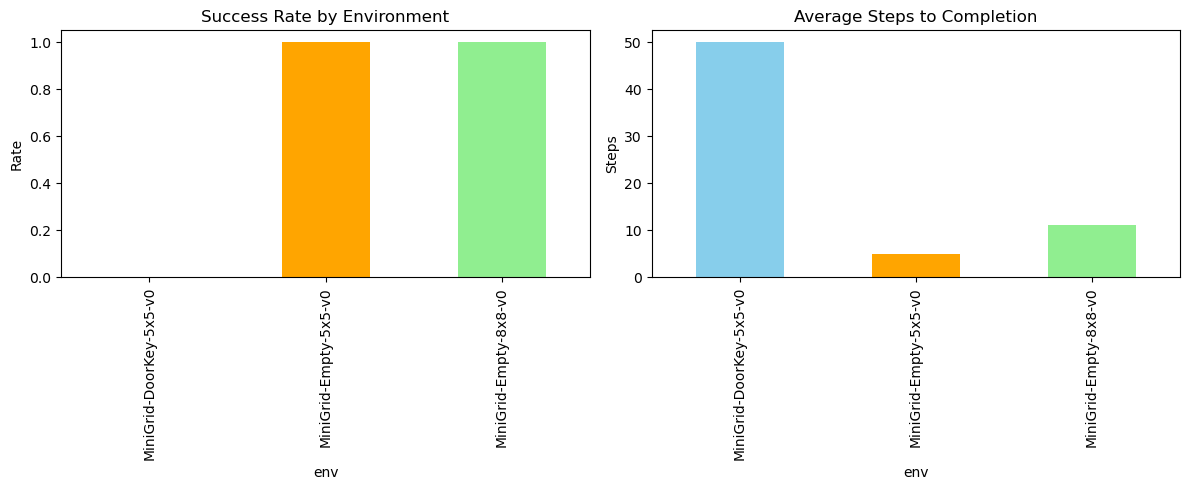


=== Summary Table ===


,success,steps,tokens,time
env,,,,
MiniGrid-DoorKey-5x5-v0,0.0,50.0,22825.6,0.000737
MiniGrid-Empty-5x5-v0,1.0,5.0,1932.0,0.000380
MiniGrid-Empty-8x8-v0,1.0,11.0,4770.0,0.000182


In [35]:
plt.figure(figsize=(12, 5))

# Success Rate
plt.subplot(1, 2, 1)
success_rates = all_results.groupby('env')['success'].mean()
success_rates.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Success Rate by Environment')
plt.ylabel('Rate')

# Average Steps
plt.subplot(1, 2, 2)
avg_steps = all_results.groupby('env')['steps'].mean()
avg_steps.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen'])
plt.title('Average Steps to Completion')
plt.ylabel('Steps')

plt.tight_layout()
plt.show()

print("\n=== Summary Table ===")
display(all_results.groupby('env')[['success', 'steps', 'tokens', 'time']].mean())